# Pairs Trading Strategy Optimization in Python with AMPL
[![Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_2_Pairs_Trading_Strategy_Optimization.ipynb)](https://colab.ampl.com)

Description: Optimize pairs trading strategy by optimizing entry and exit thresholds for each pair based on training data. This approach uses interpolation to find optimal parameters within the range tested.

Tags: finance, pairs-trading

Notebook author: Mukeshwaran Baskaran <<mukesh96official@gmail.com>>

In [47]:
# Install dependencies
%pip install amplpy yfinance matplotlib pandas numpy -q

In [48]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [49]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import logging
import matplotlib.colors as mcolors

# Define a list of distinct colors
colors = list(mcolors.TABLEAU_COLORS)  # Using Tableau colors for distinctiveness

In [50]:
# Define stock pairs and fetch data
STOCK_PAIRS = [
    ("AAPL", "MSFT"),  # Apple & Microsoft
    ("GOOGL", "META"),  # Google & Meta
    ("XOM", "CVX"),  # Exxon Mobil & Chevron
    ("AMZN", "WMT"),  # Amazon & Walmart
    ("PG", "UL"),  # Procter & Gamble & Unilever
    ("KO", "PEP"),  # Coca-Cola & PepsiCo
    ("INTC", "AMD"),  # Intel & Advanced Micro Devices
    ("TSLA", "NIO"),  # Tesla & NIO
    ("BMY", "LLY"),  # Bristol-Myers Squibb & Eli Lilly
    ("V", "MA")  # Visa & Mastercard
]

START_DATE = "2015-01-01"
END_DATE = "2025-01-01"

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Implementation

### Download historical data for stock pairs

In [51]:
def fetch_stock_data(pairs, start_date, end_date, retries=3):
    """Fetch historical data for given stock pairs with retry mechanism."""
    data = {}
    for pair in pairs:
        ticker1, ticker2 = pair
        attempt = 0
        while attempt < retries:
            try:
                data[pair] = yf.download([ticker1, ticker2], start=start_date, end=end_date)["Close"]
                logging.info(f"Successfully fetched data for {ticker1}, {ticker2}")
                break  # Successfully fetched data, break out of retry loop
            except Exception as e:
                logging.error(f"Error fetching data for {ticker1}, {ticker2}: {e}")
                attempt += 1
                if attempt < retries:
                    logging.info(f"Retrying... ({attempt}/{retries})")
                    time.sleep(5)  # Wait before retrying
                else:
                    logging.error(f"Failed to fetch data after {retries} attempts for {ticker1}, {ticker2}")
    return data

### Calculate spread and z-score

In [52]:
def calculate_spread_zscore(data, lookback=30):
    """Calculate spread and z-score for each pair."""
    spreads = {}
    z_scores = {}
    for pair in data:
        ticker1, ticker2 = pair
        spread = data[pair][ticker1] - data[pair][ticker2]
        spread_mean = spread.rolling(window=lookback).mean()
        spread_std = spread.rolling(window=lookback).std()
        z_score = (spread - spread_mean) / spread_std
        spreads[pair] = spread
        z_scores[pair] = z_score
    return spreads, z_scores

### Backtest pairs trading strategy with pair-specific parameters

In [53]:
def backtest_pairs_trading(data, z_scores, pair_params):
    """
    Backtest a pairs trading strategy using pair-specific parameters.

    Args:
        data: Dictionary of price data
        z_scores: Dictionary of z-scores
        pair_params: Dictionary mapping pair strings to (entry_threshold, exit_threshold) tuples
    """
    results = {}
    for pair in data:
        ticker1, ticker2 = pair
        pair_key = f"{ticker1}_{ticker2}"

        # Get pair-specific parameters or use defaults
        entry_threshold, exit_threshold = pair_params.get(pair_key, (1.0, 0.5))

        z_score = z_scores[pair]
        positions = pd.Series(0, index=z_score.index)
        returns = pd.Series(0.0, index=z_score.index)

        # Generate trading signals
        long_entry = z_score < -entry_threshold
        short_entry = z_score > entry_threshold
        long_exit = z_score > -exit_threshold
        short_exit = z_score < exit_threshold

        # Simulate trades
        position = 0
        for i in range(1, len(z_score)):
            if long_entry.iloc[i] and position <= 0:
                position = 1  # Go long
            elif short_entry.iloc[i] and position >= 0:
                position = -1  # Go short
            elif (long_exit.iloc[i] and position == 1) or (short_exit.iloc[i] and position == -1):
                position = 0  # Exit position

            positions.iloc[i] = position
            returns.iloc[i] = position * (data[pair][ticker1].iloc[i] - data[pair][ticker1].iloc[i-1]) / data[pair][ticker1].iloc[i-1]

        # Calculate drawdown
        cumulative_returns = returns.cumsum()
        drawdown = cumulative_returns - cumulative_returns.cummax()

        # Store results
        results[pair_key] = {
            "positions": positions,
            "returns": returns,
            "cumulative_returns": cumulative_returns,
            "drawdown": drawdown,
            "sharpe_ratio": (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
        }
    return results

### Create training data for AMPL optimization

In [54]:
def create_training_data(stock_data, z_scores, pairs, num_samples=20):
    """
    Generate training data for AMPL by running backtests with different parameters.

    Args:
        stock_data: Dictionary of price data
        z_scores: Dictionary of z-scores
        pairs: List of stock pairs
        num_samples: Number of parameter combinations to test

    Returns:
        Dictionary with pairs as keys and lists of (entry, exit, sharpe) tuples as values
    """
    # Define parameter ranges
    entry_range = np.linspace(0.5, 2.5, int(np.sqrt(num_samples)))
    exit_range = np.linspace(0.1, 1.5, int(np.sqrt(num_samples)))

    training_data = {}

    for pair in pairs:
        ticker1, ticker2 = pair
        pair_key = f"{ticker1}_{ticker2}"
        training_data[pair_key] = []

        logging.info(f"Generating training data for {pair_key}...")

        # Generate parameter combinations where entry >= exit
        valid_combinations = [(e, x) for e in entry_range for x in exit_range if e >= x]

        for entry, exit in valid_combinations:
            # Test this parameter combination
            test_params = {pair_key: (entry, exit)}
            results = backtest_pairs_trading({pair: stock_data[pair]}, {pair: z_scores[pair]}, test_params)
            sharpe = results[pair_key]["sharpe_ratio"]

            # Store the parameter combination and resulting Sharpe ratio
            training_data[pair_key].append((entry, exit, sharpe))

    return training_data

### Optimize parameters for each pair independently

In [55]:
def optimize_pair_parameters(stock_data, z_scores):
    """
    Optimize parameters for each pair individually using grid search approach.
    Returns a dictionary with optimal parameters for each pair.
    """
    # Define search grid - can be adjusted for finer/broader search
    entry_thresholds = np.linspace(0.5, 2.5, 5)  # [0.5, 1.0, 1.5, 2.0, 2.5]
    exit_thresholds = np.linspace(0.1, 1.5, 5)   # [0.1, 0.4, 0.7, 1.0, 1.3]

    optimal_params = {}

    for pair in stock_data:
        ticker1, ticker2 = pair
        pair_key = f"{ticker1}_{ticker2}"

        best_sharpe = -np.inf
        best_params = (1.0, 0.5)  # Default

        logging.info(f"Optimizing parameters for pair: {pair_key}")

        for entry in entry_thresholds:
            for exit in exit_thresholds:
                # Skip invalid combinations (entry must be >= exit)
                if entry < exit:
                    continue

                # Test this parameter combination
                test_params = {pair_key: (entry, exit)}
                results = backtest_pairs_trading({pair: stock_data[pair]}, {pair: z_scores[pair]}, test_params)
                sharpe = results[pair_key]["sharpe_ratio"]

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = (entry, exit)

        logging.info(f"Optimal parameters for {pair_key}: Entry={best_params[0]:.2f}, Exit={best_params[1]:.2f}, Sharpe={best_sharpe:.4f}")
        optimal_params[pair_key] = best_params

    return optimal_params

### Optimize parameters using AMPL for each pair

In [56]:
def optimize_with_ampl(ampl, training_data):
    """
    Use AMPL to optimize entry and exit thresholds for each pair based on training data.

    This approach uses interpolation to find optimal parameters within the range tested.
    """
    optimal_params = {}

    for pair_key in training_data:
        logging.info(f"Optimizing parameters for {pair_key} using AMPL...")

        # Extract training data for this pair
        pair_data = training_data[pair_key]
        entry_values = [p[0] for p in pair_data]
        exit_values = [p[1] for p in pair_data]
        sharpe_values = [p[2] for p in pair_data]

        # Reset AMPL model
        ampl.reset()

        # Define AMPL model for interpolation and optimization
        ampl.eval(r"""
            # Sets for parameter combinations
            set SAMPLES;

            # Parameters for each sample
            param entry_threshold {SAMPLES};
            param exit_threshold {SAMPLES};
            param sharpe_ratio {SAMPLES};

            # Decision variables for optimal thresholds
            var opt_entry >= 0.5, <= 2.5;
            var opt_exit >= 0.1, <= 1.5;

            # RBF kernel function for interpolation (Gaussian)
            param sigma := 0.3;  # Width parameter for RBF kernel

            # RBF kernel function: exp(-||x - y||^2 / (2*sigma^2))
            function rbf_kernel(x1, y1, x2, y2) =
                exp(-((x1 - x2)^2 + (y1 - y2)^2) / (2*sigma^2));

            # Interpolated objective function using RBF kernel
            maximize predicted_sharpe:
                sum {s in SAMPLES} sharpe_ratio[s] *
                rbf_kernel(opt_entry, opt_exit, entry_threshold[s], exit_threshold[s]) /
                sum {t in SAMPLES} rbf_kernel(opt_entry, opt_exit, entry_threshold[t], exit_threshold[t]);

            # Constraint: entry threshold must be greater than or equal to exit threshold
            subject to threshold_constraint:
                opt_entry >= opt_exit;
        """)

        # Set data in AMPL
        ampl.set["SAMPLES"] = list(range(len(pair_data)))
        ampl.param["entry_threshold"] = {i: pair_data[i][0] for i in range(len(pair_data))}
        ampl.param["exit_threshold"] = {i: pair_data[i][1] for i in range(len(pair_data))}
        ampl.param["sharpe_ratio"] = {i: pair_data[i][2] for i in range(len(pair_data))}

        # Solve the optimization problem
        try:
            ampl.solve(solver="knitro", knitro_options="outlev=1")

            # Extract optimized parameters
            opt_entry = ampl.var["opt_entry"].value()
            opt_exit = ampl.var["opt_exit"].value()
            predicted_sharpe = ampl.obj["predicted_sharpe"].value()

            logging.info(f"AMPL optimization for {pair_key}: Entry={opt_entry:.2f}, Exit={opt_exit:.2f}, Predicted Sharpe={predicted_sharpe:.4f}")

            optimal_params[pair_key] = (opt_entry, opt_exit)
        except Exception as e:
            logging.error(f"AMPL optimization failed for {pair_key}: {e}")
            # Fallback to best sample if optimization fails
            best_idx = np.argmax(sharpe_values)
            optimal_params[pair_key] = (entry_values[best_idx], exit_values[best_idx])
            logging.info(f"Falling back to best sample: Entry={entry_values[best_idx]:.2f}, Exit={exit_values[best_idx]:.2f}")

    return optimal_params

### Plot parameter heatmap with AMPL solution

In [57]:
def plot_parameter_heatmap(training_data, optimal_params, pair_key):
    """Plot heatmap of Sharpe ratios with AMPL's optimal solution."""
    # Extract data for visualization
    entry_values = [p[0] for p in training_data[pair_key]]
    exit_values = [p[1] for p in training_data[pair_key]]
    sharpe_values = [p[2] for p in training_data[pair_key]]

    # Create a grid for the heatmap
    entry_grid = np.linspace(min(entry_values), max(entry_values), 50)
    exit_grid = np.linspace(min(exit_values), max(exit_values), 50)

    # Create mesh grid
    X, Y = np.meshgrid(exit_grid, entry_grid)
    Z = np.zeros(X.shape)

    # Fill Z with interpolated values using RBF kernel
    sigma = 0.3  # Same as in AMPL model
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if entry_grid[i] < exit_grid[j]:  # Skip invalid regions
                Z[i, j] = np.nan
                continue

            # RBF interpolation
            weights = np.exp(-((entry_grid[i] - np.array(entry_values))**2 +
                             (exit_grid[j] - np.array(exit_values))**2) / (2 * sigma**2))
            if np.sum(weights) > 0:
                Z[i, j] = np.sum(weights * np.array(sharpe_values)) / np.sum(weights)
            else:
                Z[i, j] = np.nan

    # Create plot
    plt.figure(figsize=(10, 8))

    # Plot heatmap
    cmap = plt.cm.viridis
    cmap.set_bad('white', 1.0)
    heatmap = plt.pcolormesh(X, Y, Z, cmap=cmap, shading='auto')

    plt.colorbar(heatmap, label='Interpolated Sharpe Ratio')
    plt.title(f'Parameter Optimization Landscape for {pair_key}')
    plt.xlabel('Exit Threshold')
    plt.ylabel('Entry Threshold')

    # Add contour lines
    contour = plt.contour(X, Y, Z, colors='white', alpha=0.5)
    plt.clabel(contour, inline=True, fontsize=8)

    # Plot training data points
    plt.scatter(exit_values, entry_values, c=sharpe_values, cmap='viridis',
                s=50, edgecolor='black', label='Training Samples')

    # Mark the AMPL optimal solution
    opt_entry, opt_exit = optimal_params[pair_key]
    plt.scatter([opt_exit], [opt_entry], color='red', s=200, marker='*',
                label=f'AMPL Optimal: Entry={opt_entry:.2f}, Exit={opt_exit:.2f}')

    # Diagonal line showing the constraint boundary
    diag_x = np.linspace(min(exit_grid), max(exit_grid), 100)
    plt.plot(diag_x, diag_x, 'r--', alpha=0.7, label='Constraint: Entry ≥ Exit')

    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot cumulative returns for unoptimized strategy

In [58]:
def plot_cumulative_returns_unoptimized(unoptimized_results):
    """Plot cumulative returns for unoptimized strategy."""
    plt.figure(figsize=(12, 6))

    # Plot unoptimized cumulative returns with different colors
    for i, pair in enumerate(unoptimized_results):
        plt.plot(unoptimized_results[pair]["cumulative_returns"],
                 label=f"{pair} (Unoptimized)",
                 linestyle='--',
                 color=colors[i % len(colors)])

    plt.title("Cumulative Returns for Pairs Trading Strategy (Unoptimized)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plot cumulative returns for optimized strategy

In [59]:
def plot_cumulative_returns_optimized(optimized_results):
    """Plot cumulative returns for optimized strategy."""
    plt.figure(figsize=(12, 6))

    # Plot optimized cumulative returns with different colors
    for i, pair in enumerate(optimized_results):
        plt.plot(optimized_results[pair]["cumulative_returns"],
                 label=f"{pair} (Optimized)",
                 linestyle='-',
                 color=colors[i % len(colors)])

    plt.title("Cumulative Returns for Pairs Trading Strategy (Optimized)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plot Sharpe ratio for unoptimized strategy

In [60]:
def plot_sharpe_ratio_unoptimized(unoptimized_results):
    """Plot Sharpe ratio for unoptimized strategy."""
    sharpe_ratios_before = {pair: unoptimized_results[pair]["sharpe_ratio"] for pair in unoptimized_results}

    plt.figure(figsize=(12, 6))

    # Plot Sharpe ratios for unoptimized with different colors
    for i, pair in enumerate(sharpe_ratios_before):
        plt.bar(i, sharpe_ratios_before[pair],
                label=f"{pair}",
                alpha=0.6,
                color=colors[i % len(colors)])

    plt.title("Sharpe Ratio for Pairs Trading Strategy (Unoptimized)")
    plt.xlabel("Pairs")
    plt.ylabel("Sharpe Ratio")
    plt.xticks(range(len(sharpe_ratios_before)), sharpe_ratios_before.keys(), rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

### Plot Sharpe ratio for optimized strategy

In [61]:
def plot_sharpe_ratio_optimized(optimized_results):
    """Plot Sharpe ratio for optimized strategy."""
    sharpe_ratios_after = {pair: optimized_results[pair]["sharpe_ratio"] for pair in optimized_results}

    plt.figure(figsize=(12, 6))

    # Plot Sharpe ratios for optimized with different colors
    for i, pair in enumerate(sharpe_ratios_after):
        plt.bar(i, sharpe_ratios_after[pair],
                label=f"{pair}",
                alpha=0.6,
                color=colors[i % len(colors)])

    plt.title("Sharpe Ratio for Pairs Trading Strategy (Optimized)")
    plt.xlabel("Pairs")
    plt.ylabel("Sharpe Ratio")
    plt.xticks(range(len(sharpe_ratios_after)), sharpe_ratios_after.keys(), rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

### Plot drawdown for unoptimized strategy

In [62]:
def plot_drawdown_unoptimized(unoptimized_results):
    """Plot drawdown for unoptimized strategy."""
    plt.figure(figsize=(12, 6))

    # Plot unoptimized drawdowns with different colors
    for i, pair in enumerate(unoptimized_results):
        plt.plot(unoptimized_results[pair]["drawdown"],
                 label=f"{pair} (Unoptimized)",
                 linestyle='--',
                 color=colors[i % len(colors)])

    plt.title("Drawdown for Pairs Trading Strategy (Unoptimized)")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plot drawdown for optimized strategy

In [63]:
def plot_drawdown_optimized(optimized_results):
    """Plot drawdown for optimized strategy."""
    plt.figure(figsize=(12, 6))

    # Plot optimized drawdowns with different colors
    for i, pair in enumerate(optimized_results):
        plt.plot(optimized_results[pair]["drawdown"],
                 label=f"{pair} (Optimized)",
                 linestyle='-',
                 color=colors[i % len(colors)])

    plt.title("Drawdown for Pairs Trading Strategy (Optimized)")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Plot comparison of unoptimized vs optimized Sharpe ratios

In [64]:
def plot_sharpe_comparison(unoptimized_results, optimized_results):
    """Plot comparison of Sharpe ratios before and after optimization."""
    pairs = sorted(unoptimized_results.keys())
    sharpe_before = [unoptimized_results[p]["sharpe_ratio"] for p in pairs]
    sharpe_after = [optimized_results[p]["sharpe_ratio"] for p in pairs]

    x = np.arange(len(pairs))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, sharpe_before, width, label='Unoptimized', alpha=0.7)
    rects2 = ax.bar(x + width/2, sharpe_after, width, label='Optimized', alpha=0.7)

    ax.set_title('Sharpe Ratio Comparison: Unoptimized vs. Optimized')
    ax.set_xlabel('Pairs')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xticks(x)
    ax.set_xticklabels(pairs, rotation=45)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')

    fig.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

### Plot parameter heatmap to visualize the optimization landscape for a specific pair

In [65]:
def plot_parameter_heatmap(stock_data, z_scores, pair_index=0):
    """Plot heatmap of Sharpe ratios for different parameter combinations."""
    # Select a pair for visualization
    pair = list(stock_data.keys())[pair_index]
    ticker1, ticker2 = pair
    pair_key = f"{ticker1}_{ticker2}"

    # Define search grid with finer resolution for visualization
    entry_thresholds = np.linspace(0.5, 2.5, 10)
    exit_thresholds = np.linspace(0.1, 1.5, 10)

    # Create empty grid for heatmap data
    sharpe_grid = np.zeros((len(entry_thresholds), len(exit_thresholds)))
    sharpe_grid[:] = np.nan  # Fill with NaN for invalid combinations

    # Calculate Sharpe ratios for parameter combinations
    for i, entry in enumerate(entry_thresholds):
        for j, exit in enumerate(exit_thresholds):
            # Skip invalid combinations (entry must be >= exit)
            if entry < exit:
                continue

            # Test this parameter combination
            test_params = {pair_key: (entry, exit)}
            results = backtest_pairs_trading({pair: stock_data[pair]}, {pair: z_scores[pair]}, test_params)
            sharpe = results[pair_key]["sharpe_ratio"]
            sharpe_grid[i, j] = sharpe

    # Create heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.pcolormesh(exit_thresholds, entry_thresholds, sharpe_grid,
                             cmap='viridis', shading='auto')

    plt.colorbar(heatmap, label='Sharpe Ratio')
    plt.title(f'Parameter Optimization Landscape for {pair_key}')
    plt.xlabel('Exit Threshold')
    plt.ylabel('Entry Threshold')

    # Add contour lines
    contour = plt.contour(exit_thresholds, entry_thresholds, sharpe_grid,
                          colors='white', alpha=0.5)
    plt.clabel(contour, inline=True, fontsize=8)

    # Mark the optimal point
    optimal_params = optimize_pair_parameters({pair: stock_data[pair]}, {pair: z_scores[pair]})
    opt_entry, opt_exit = optimal_params[pair_key]
    plt.scatter([opt_exit], [opt_entry], color='red', s=100, marker='*',
                label=f'Optimal: Entry={opt_entry:.2f}, Exit={opt_exit:.2f}')

    plt.legend()
    plt.tight_layout()
    plt.show()

### Print optimization summary showing parameters and performance

In [66]:
def print_optimization_summary(optimized_params, unoptimized_results, optimized_results):
    """Print a summary of the optimization results."""
    print("\n" + "="*80)
    print("PAIRS TRADING STRATEGY OPTIMIZATION SUMMARY")
    print("="*80)

    print("\nOptimized Parameters:")
    print("-"*50)
    print(f"{'Pair':<15} {'Entry Threshold':<20} {'Exit Threshold':<20}")
    print("-"*50)

    for pair_key in sorted(optimized_params.keys()):
        entry, exit = optimized_params[pair_key]
        print(f"{pair_key:<15} {entry:<20.2f} {exit:<20.2f}")

    print("\nPerformance Comparison:")
    print("-"*80)
    print(f"{'Pair':<15} {'Unopt. Sharpe':<15} {'Opt. Sharpe':<15} {'Improvement':<15} {'% Change':<15}")
    print("-"*80)

    total_before = 0
    total_after = 0

    for pair_key in sorted(unoptimized_results.keys()):
        before = unoptimized_results[pair_key]["sharpe_ratio"]
        after = optimized_results[pair_key]["sharpe_ratio"]
        improvement = after - before
        percent_change = (improvement / abs(before)) * 100 if before != 0 else float('inf')

        print(f"{pair_key:<15} {before:<15.4f} {after:<15.4f} {improvement:<+15.4f} {percent_change:<+15.2f}%")

        total_before += before
        total_after += after

    total_improvement = total_after - total_before
    total_percent = (total_improvement / abs(total_before)) * 100 if total_before != 0 else float('inf')

    print("-"*80)
    print(f"{'TOTAL':<15} {total_before:<15.4f} {total_after:<15.4f} {total_improvement:<+15.4f} {total_percent:<+15.2f}%")
    print("="*80)

### Compare all metrics between optimized and unoptimized strategies

In [67]:
def compare_strategies(unoptimized_results, optimized_results):
    """Calculate and compare key metrics between strategies."""
    metrics = {}

    for strategy, results in [("Unoptimized", unoptimized_results), ("Optimized", optimized_results)]:
        # Calculate portfolio-level metrics
        all_returns = pd.DataFrame({pair: results[pair]["returns"] for pair in results})
        portfolio_returns = all_returns.mean(axis=1)  # Equal-weighted portfolio

        cum_returns = portfolio_returns.cumsum()
        drawdown = cum_returns - cum_returns.cummax()

        # Calculate metrics
        metrics[strategy] = {
            "Total Return": cum_returns.iloc[-1],
            "Annualized Return": portfolio_returns.mean() * 252,
            "Annualized Volatility": portfolio_returns.std() * np.sqrt(252),
            "Sharpe Ratio": (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252),
            "Max Drawdown": drawdown.min(),
            "Calmar Ratio": (portfolio_returns.mean() * 252) / abs(drawdown.min()) if drawdown.min() < 0 else np.inf,
            "Winning Pairs": sum(1 for p in results if results[p]["cumulative_returns"].iloc[-1] > 0),
            "Total Pairs": len(results)
        }

    # Create comparison DataFrame
    comparison = pd.DataFrame({k: v for k, v in metrics.items()})

    # Calculate improvement
    improvement = comparison["Optimized"] - comparison["Unoptimized"]
    percent_change = (improvement / comparison["Unoptimized"].abs()) * 100

    comparison["Improvement"] = improvement
    comparison["% Change"] = percent_change

    return comparison

### Plot portfolio returns comparison

In [68]:
def plot_portfolio_comparison(unoptimized_results, optimized_results):
    """Plot comparison of portfolio returns."""
    # Calculate portfolio returns for each strategy
    unopt_returns = pd.DataFrame({pair: unoptimized_results[pair]["returns"] for pair in unoptimized_results})
    opt_returns = pd.DataFrame({pair: optimized_results[pair]["returns"] for pair in optimized_results})

    unopt_portfolio = unopt_returns.mean(axis=1).cumsum()
    opt_portfolio = opt_returns.mean(axis=1).cumsum()

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(unopt_portfolio, label='Unoptimized Portfolio', linestyle='--', color='blue', alpha=0.7)
    plt.plot(opt_portfolio, label='Optimized Portfolio', linestyle='-', color='green')

    plt.title('Equal-Weighted Portfolio Performance: Unoptimized vs. Optimized')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Execution

### Fetch data

In [69]:
logging.info("Fetching stock data...")
stock_data = fetch_stock_data(STOCK_PAIRS, START_DATE, END_DATE)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


### Calculate spread and z-score


In [70]:
logging.info("Calculating spreads and z-scores...")
spreads, z_scores = calculate_spread_zscore(stock_data)

### Default parameters for unoptimized strategy

In [71]:
default_entry_threshold = 1.0
default_exit_threshold = 0.5
default_params = {f"{p[0]}_{p[1]}": (default_entry_threshold, default_exit_threshold) for p in stock_data}

### Backtest with default parameters

In [72]:
logging.info("Running backtest with default parameters...")
unoptimized_results = backtest_pairs_trading(stock_data, z_scores, default_params)

### Optimize parameters for each pair

In [73]:
logging.info("Starting parameter optimization for each pair...")
optimized_params = optimize_pair_parameters(stock_data, z_scores)

### Backtest with optimized parameters

In [74]:
logging.info("Running backtest with optimized parameters...")
optimized_results = backtest_pairs_trading(stock_data, z_scores, optimized_params)

### Print optimization summary

In [75]:
print_optimization_summary(optimized_params, unoptimized_results, optimized_results)


PAIRS TRADING STRATEGY OPTIMIZATION SUMMARY

Optimized Parameters:
--------------------------------------------------
Pair            Entry Threshold      Exit Threshold      
--------------------------------------------------
AAPL_MSFT       1.50                 1.50                
AMZN_WMT        2.50                 0.10                
BMY_LLY         0.50                 0.45                
GOOGL_META      1.50                 1.50                
INTC_AMD        2.00                 0.80                
KO_PEP          1.50                 1.50                
PG_UL           2.50                 0.10                
TSLA_NIO        2.50                 0.10                
V_MA            1.50                 1.50                
XOM_CVX         0.50                 0.45                

Performance Comparison:
--------------------------------------------------------------------------------
Pair            Unopt. Sharpe   Opt. Sharpe     Improvement     % Change       
------

### Compare overall portfolio metrics

In [76]:
comparison = compare_strategies(unoptimized_results, optimized_results)
print("\nPortfolio-Level Performance Metrics:")
print(comparison)


Portfolio-Level Performance Metrics:
                       Unoptimized  Optimized  Improvement    % Change
Total Return             -1.307319   0.254762     1.562081  119.487345
Annualized Return        -0.130940   0.025517     0.156456  119.487345
Annualized Volatility     0.079401   0.072114    -0.007287   -9.176942
Sharpe Ratio             -1.649095   0.353836     2.002931  121.456385
Max Drawdown             -1.324193  -0.278560     1.045633   78.963812
Calmar Ratio             -0.098883   0.091602     0.190485  192.637244
Winning Pairs             5.000000   5.000000     0.000000    0.000000
Total Pairs              10.000000  10.000000     0.000000    0.000000


### Plot results

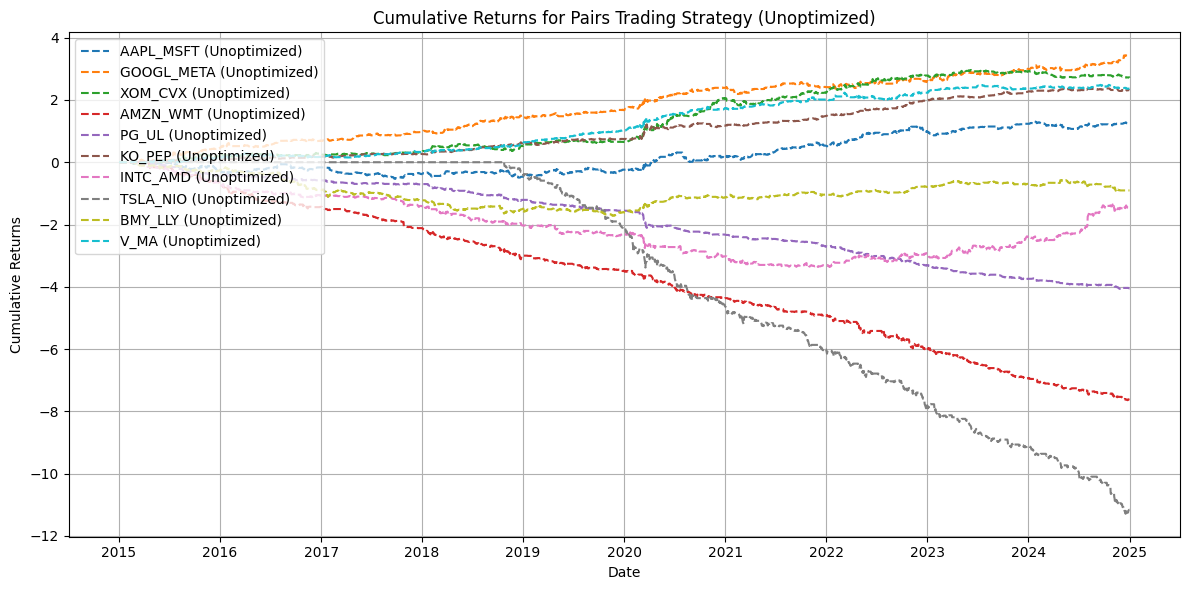

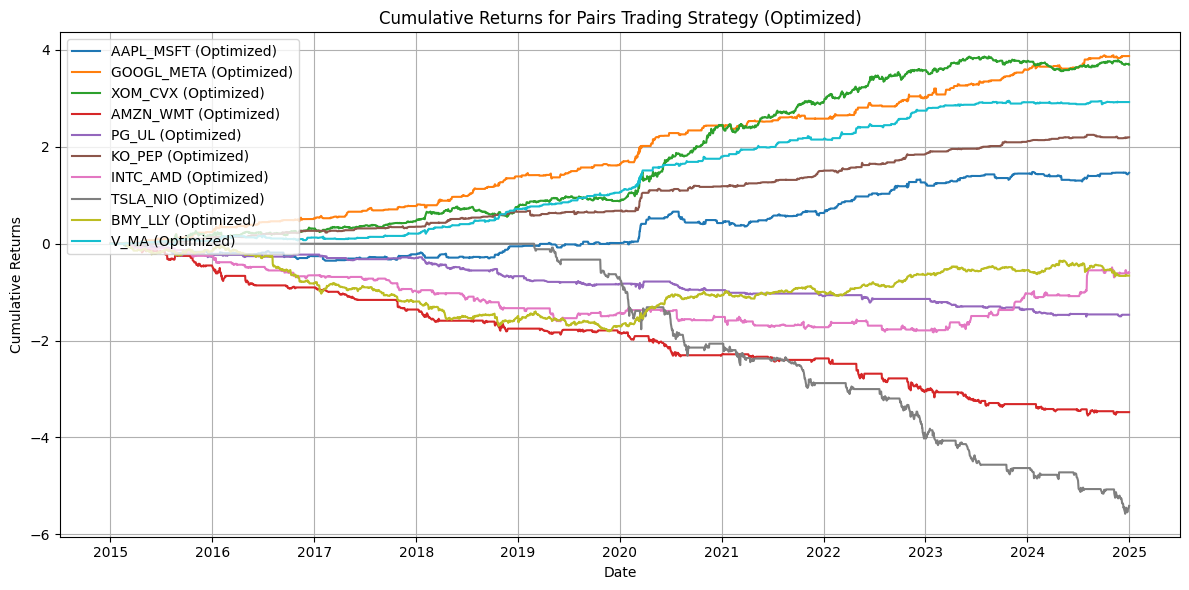

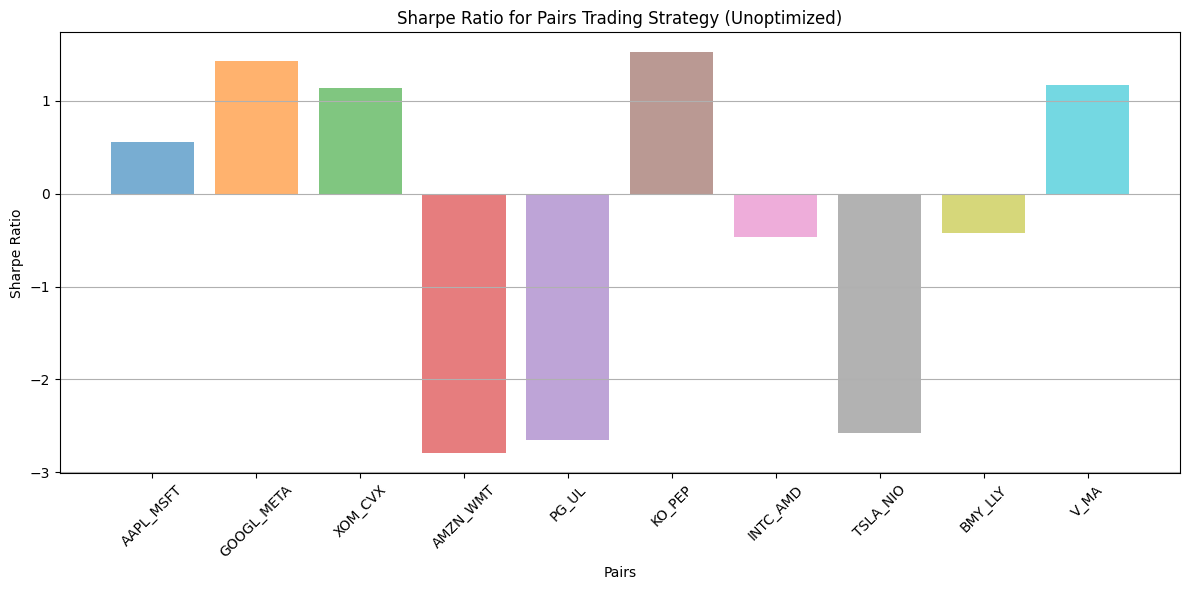

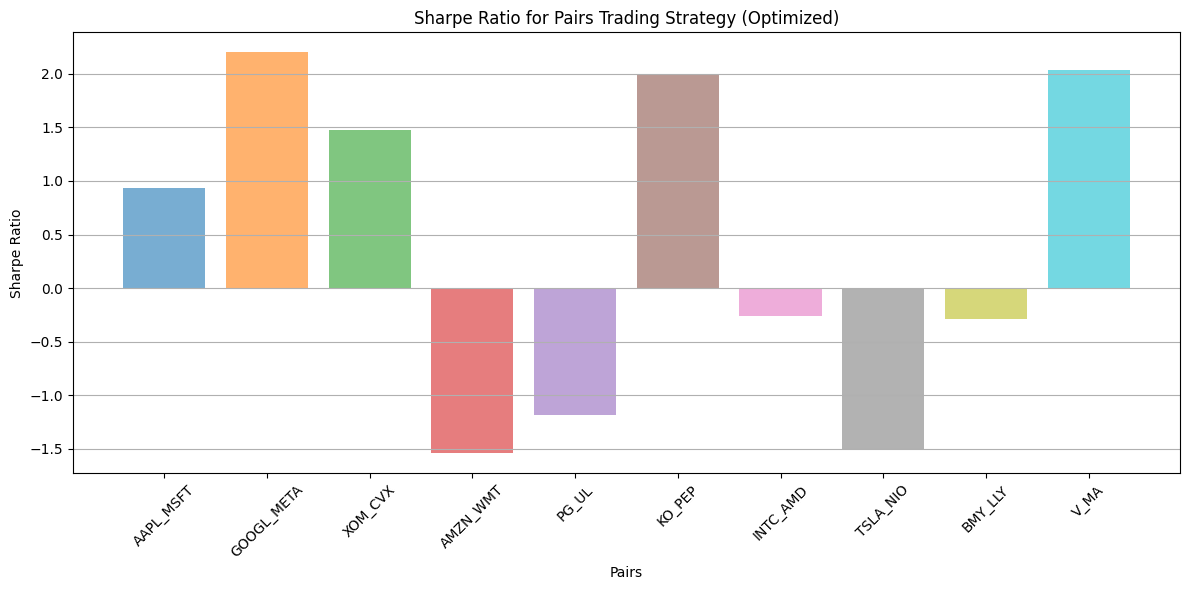

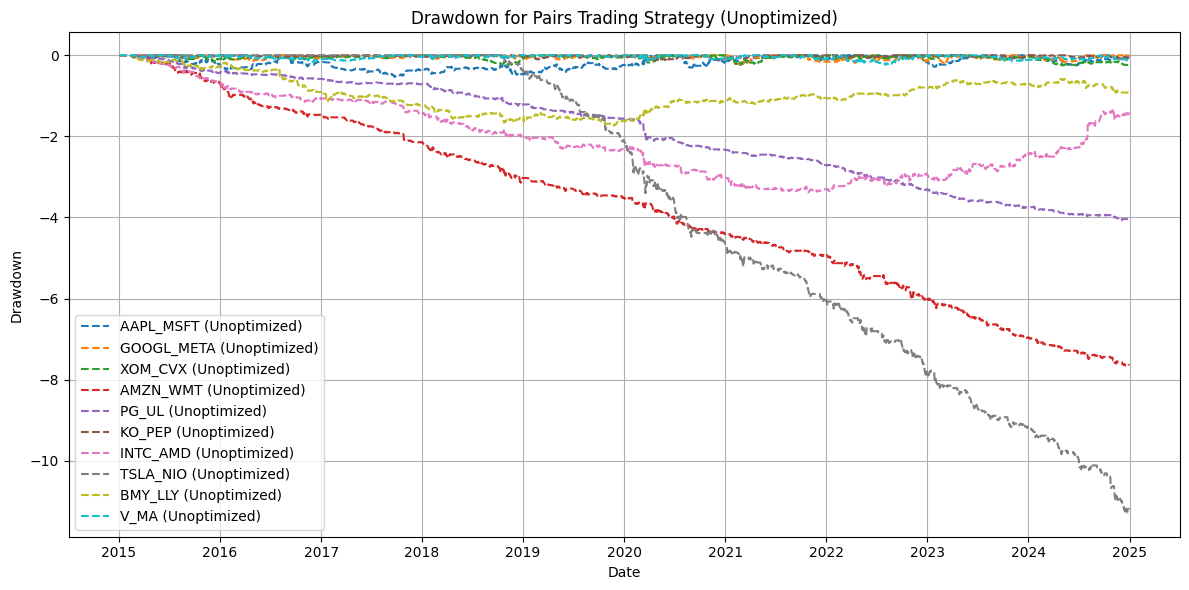

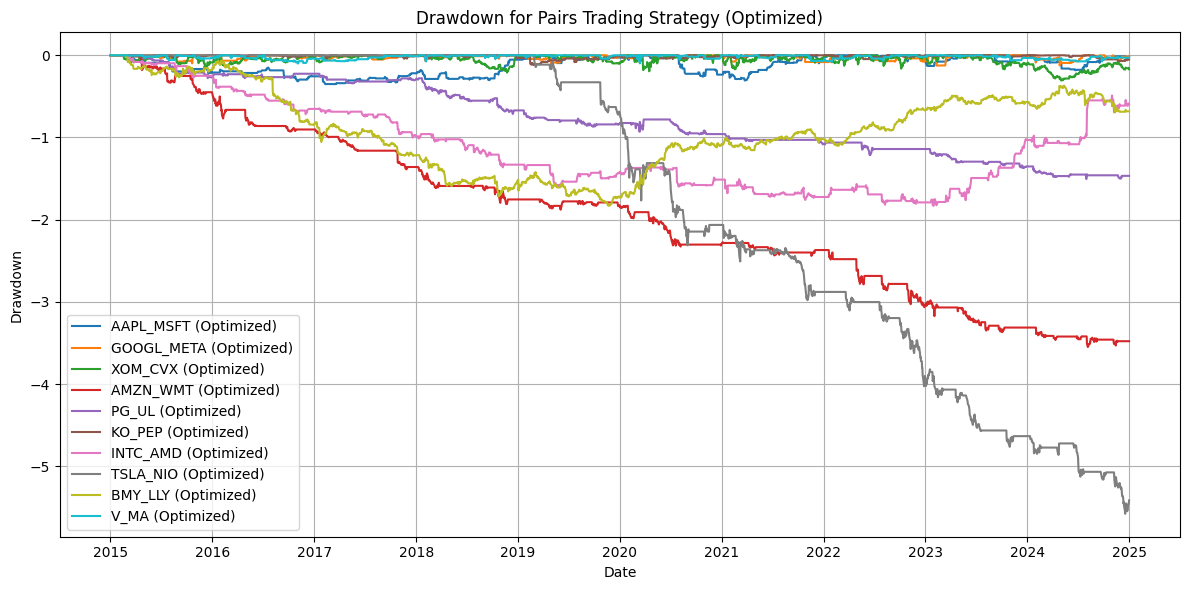

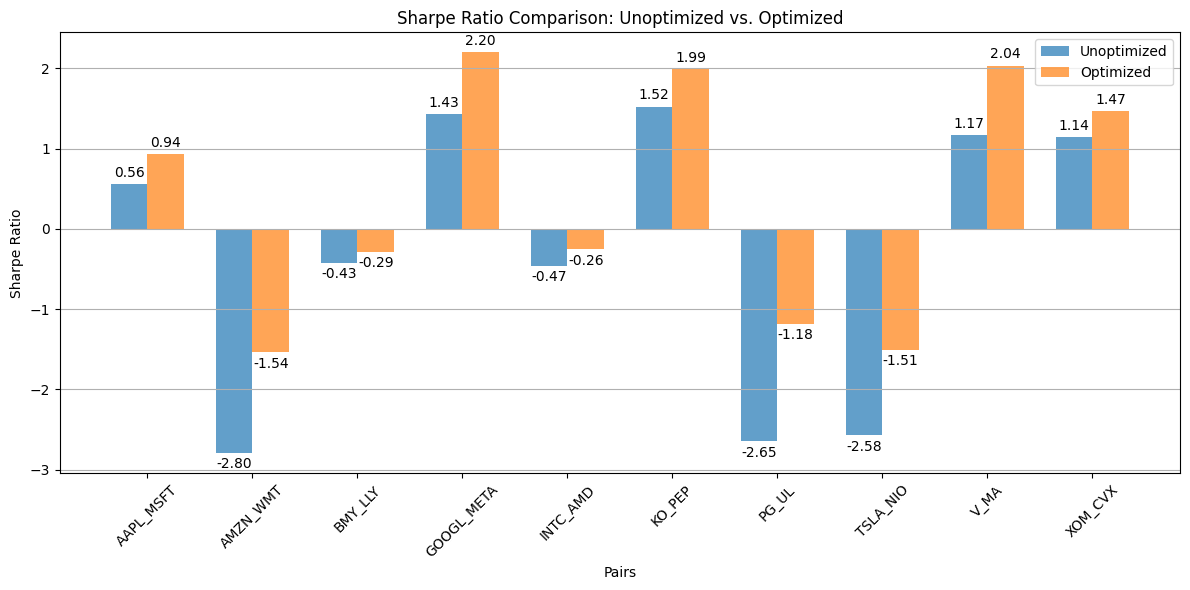

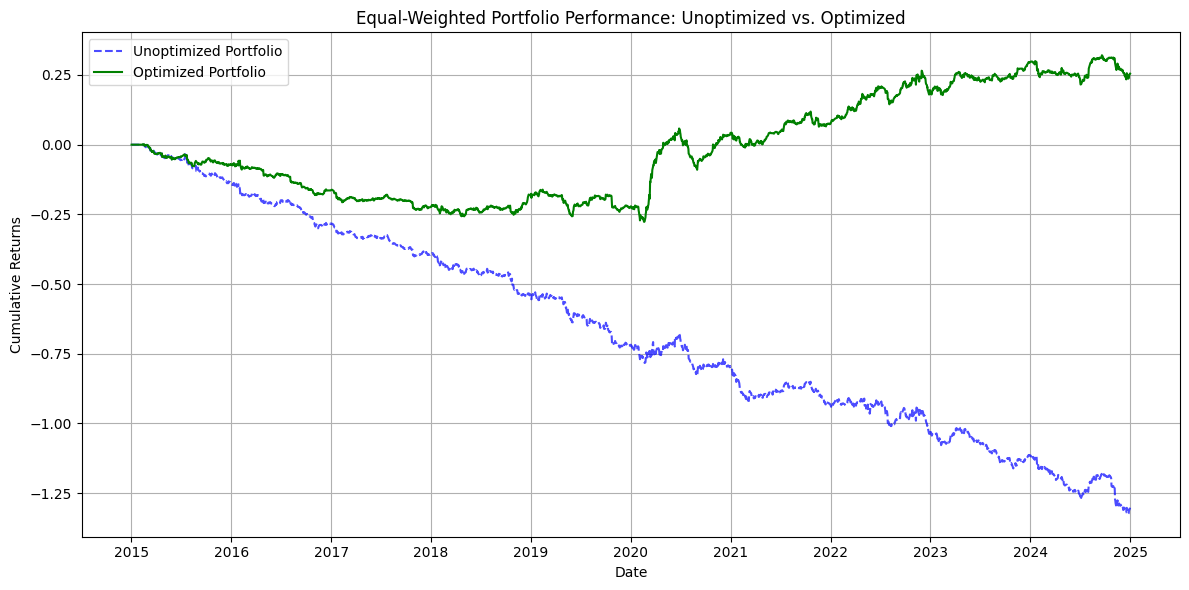

In [77]:
logging.info("Generating visualization plots...")
plot_cumulative_returns_unoptimized(unoptimized_results)
plot_cumulative_returns_optimized(optimized_results)
plot_sharpe_ratio_unoptimized(unoptimized_results)
plot_sharpe_ratio_optimized(optimized_results)
plot_drawdown_unoptimized(unoptimized_results)
plot_drawdown_optimized(optimized_results)
plot_sharpe_comparison(unoptimized_results, optimized_results)
plot_portfolio_comparison(unoptimized_results, optimized_results)

### Plot parameter heatmap for first pair (as an example)

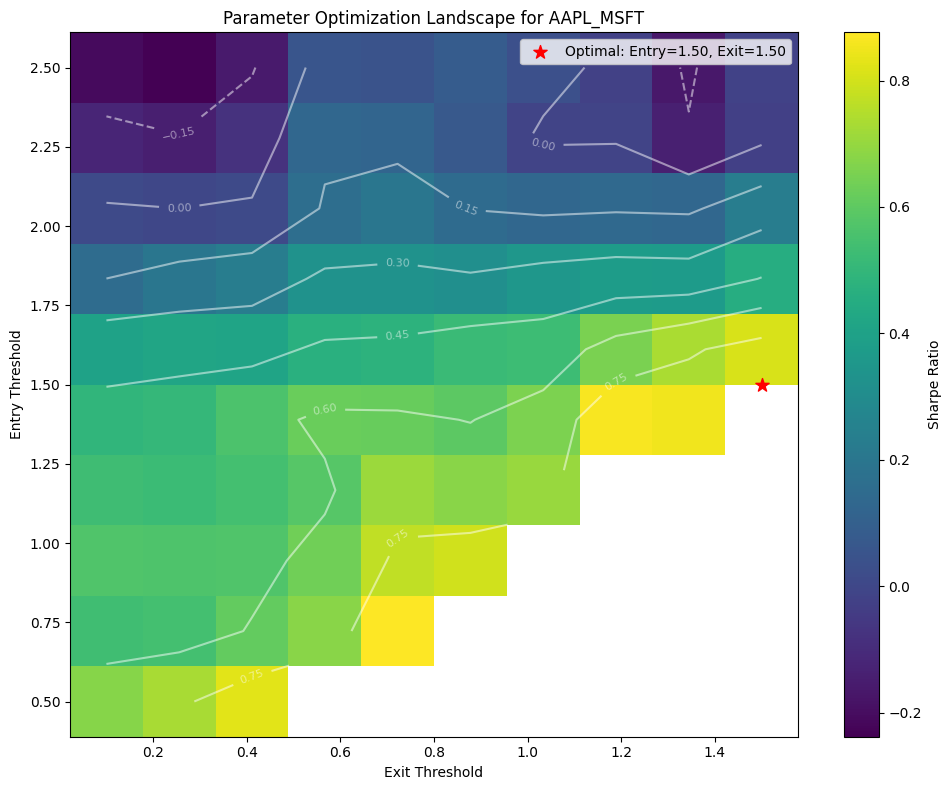

In [78]:
if stock_data:
    logging.info("Generating parameter optimization heatmap...")
    plot_parameter_heatmap(stock_data, z_scores, pair_index=0)

logging.info("Analysis complete.")